# Imports

In [1]:
# Imports
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, plot_confusion_matrix, auc, roc_curve, roc_auc_score, average_precision_score

from sklearn.neighbors import NearestNeighbors

# from imblearn.over_sampling import RandomOverSampler, SMOTE

# measuring fairness
from fairlearn.metrics import (
    count,
    demographic_parity_difference,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
    MetricFrame,
    make_derived_metric,
    selection_rate,  
)
from sklearn.metrics import precision_score
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt

from random import sample
# from random import choice

import warnings
warnings.filterwarnings("ignore")

# COMPAS data cleaning

In [2]:
compas_raw = pd.read_csv("compas-scores-two-years.csv")

In [3]:
compas_raw

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


In [4]:
compas_raw.isna().sum()

id                            0
name                          0
first                         0
last                          0
compas_screening_date         0
sex                           0
dob                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest     307
c_jail_in                   307
c_jail_out                  307
c_case_number                22
c_offense_date             1159
c_arrest_date              6077
c_days_from_compas           22
c_charge_degree               0
c_charge_desc                29
is_recid                      0
r_case_number              3743
r_charge_degree            3743
r_days_from_arrest         4898
r_offense_date             3743
r_charge_desc              3801
r_jail_in                  4898
r_jail_o

In [5]:
# filter similar to propublica
compas_drop = compas_raw[
    (compas_raw["days_b_screening_arrest"] <= 30)
    & (compas_raw["days_b_screening_arrest"] >= -30)
    & (compas_raw["is_recid"] != -1)
    & (compas_raw["c_charge_degree"] != "O")
    & (compas_raw["score_text"] != "N/A")
]

compas_drop = compas_drop[["sex", "age", "race", "priors_count", 'c_charge_degree', "two_year_recid"]]

compas_drop.head()

,sex,age,race,priors_count,c_charge_degree,two_year_recid
0,Male,69,Other,0,F,0
1,Male,34,African-American,0,F,1
2,Male,24,African-American,4,F,1
5,Male,44,Other,0,M,0
6,Male,41,Caucasian,14,F,1


In [6]:
compas_drop['race'].unique()

array(['Other', 'African-American', 'Caucasian', 'Hispanic', 'Asian',
       'Native American'], dtype=object)

In [7]:
compas_bin = compas_drop[(compas_drop['race'] == 'African-American') | (compas_drop['race'] == 'Caucasian')]

In [8]:
compas_bin.reset_index(drop=True)

,sex,age,race,priors_count,c_charge_degree,two_year_recid
0,Male,34,African-American,0,F,1
1,Male,24,African-American,4,F,1
2,Male,41,Caucasian,14,F,1
3,Female,39,Caucasian,0,M,0
4,Male,27,Caucasian,0,F,0
...,...,...,...,...,...,...
5273,Male,30,African-American,0,M,1
5274,Male,20,African-American,0,F,0
5275,Male,23,African-American,0,F,0
5276,Male,23,African-American,0,F,0


In [9]:
compas_bin['two_year_recid'].value_counts()

0    2795
1    2483
Name: two_year_recid, dtype: int64

In [10]:
compas_bin.value_counts(['race', 'two_year_recid']).to_frame()

0
race             two_year_recid      
African-American 1               1661
                 0               1514
Caucasian        0               1281
                 1                822

In [11]:
compas = compas_bin

In [12]:
compas['sex'] = (compas['sex'] == 'Male').astype(int) # Male = 1, Female = 0
compas['race'] = (compas['race'] == 'Caucasian').astype(int) # Caucasian = 1, African-American = 0
compas['c_charge_degree'] = (compas['c_charge_degree'] == 'F').astype(int) # F = 1, M = 0
compas.nunique() # Check if there are any other values

sex                 2
age                62
race                2
priors_count       36
c_charge_degree     2
two_year_recid      2
dtype: int64

## Base rate

In [13]:
def base_rate_compas(data):
    # by choosing y_pred to be ground truth instead of predictions, we can easily compute the base rate in the data
    mf = MetricFrame(
        metrics={"base rate": selection_rate},
        y_true=data["two_year_recid"],  # y_true is ignored
        y_pred=data["two_year_recid"],
        sensitive_features=data["race"],
    )
    display(mf.by_group)

    # summarize demographic parity as the max difference between groups
    print("Base rate diff: %.2f" % mf.difference(method="between_groups"))
    
    
    crtr = data['two_year_recid'].sum() / len(data) # class rate
    print('Class rate: %.4f' % crtr)
    
    grtr = data['race'].sum() / len(data) # group rate
    print('Group rate: %.4f' % grtr)

In [14]:
base_rate_compas(compas)

,base rate
race,
0,0.52315
1,0.39087


Base rate diff: 0.13
Class rate: 0.4704
Group rate: 0.3984


# Data sets

In [15]:
# Train test split
rs = 0 # Random State

trainset, testset = train_test_split(compas, test_size=0.25, random_state=rs)

In [16]:
def get_max():
    m = 0
    for s in (0, 1):
        for c in (0, 1):
            data_temp = trainset[(trainset['race'] == s) & (trainset['two_year_recid'] == c)]
            if m < len(data_temp):
                m = len(data_temp)
    return m

In [17]:
base_rate_compas(testset)

,base rate
race,
0,0.496847
1,0.383302


Base rate diff: 0.11
Class rate: 0.4515
Group rate: 0.3992


## Uncorrected data set

In [18]:
data_uncorrected = trainset

In [19]:
base_rate_compas(data_uncorrected)

,base rate
race,
0,0.531906
1,0.393401


Base rate diff: 0.14
Class rate: 0.4768
Group rate: 0.3982


## Naive oversampling

In [20]:
empty = trainset[trainset['two_year_recid'] == 3]
print(empty)

Empty DataFrame
Columns: [sex, age, race, priors_count, c_charge_degree, two_year_recid]
Index: []


In [21]:
data_naive_oversampling = empty

m = get_max()

for s in (0, 1):
    for c in (0, 1):
        data_temp = trainset[(trainset['race'] == s) & (trainset['two_year_recid'] == c)]
        while len(data_temp) < m - 100:
            data_temp = data_temp.append(data_temp.sample(100))
        while len(data_temp) < m:
            data_temp = data_temp.append(data_temp.sample())
        data_naive_oversampling = data_naive_oversampling.append(data_temp)
        
data_naive_oversampling = data_naive_oversampling.reset_index(drop=True)

In [22]:
base_rate_compas(data_naive_oversampling)

,base rate
race,
0,0.5
1,0.5


Base rate diff: 0.00
Class rate: 0.5000
Group rate: 0.5000


## Uniform Sampling

In [23]:
data_uniform_sampling = empty

for s in (0, 1):
    for c in (0, 1):
        data_temp = trainset[(trainset['race'] == s) & (trainset['two_year_recid'] == c)]
        w = (len(trainset[(trainset['race'] == s)]) * len(trainset[(trainset['two_year_recid'] == c)])) / (len(trainset) * len(data_temp))
        size = int(w * len(data_temp))
        new = data_temp.sample()
        while len(new) < size - 100:
            new = new.append(data_temp.sample(100))
        while len(new) < size:
            new = new.append(data_temp.sample())
        # print(len(new))
        data_uniform_sampling = data_uniform_sampling.append(new)
        
data_uniform_sampling = data_uniform_sampling.reset_index(drop=True)

In [24]:
base_rate_compas(data_uniform_sampling)

,base rate
race,
0,0.47669
1,0.476825


Base rate diff: 0.00
Class rate: 0.4767
Group rate: 0.3981


## Fair-SMOTE

In [25]:
data_fair_smote = empty

m = get_max()

cr, f = 0.8, 0.8
probab = [cr+(1-cr)/3, (1-cr)/3, (1-cr)/3]
        
def get_neighbors(data, nbrs):
    parent = data.sample()
    arr1 = nbrs.kneighbors(parent, return_distance=False)[0]
    arr2 = [a for a in arr1 if (a != parent.index)]

    neigh1 = data.iloc[arr2[0]]
    neigh2 = data.iloc[arr2[1]]
    return parent, neigh1, neigh2
            
for s in (0, 1):
    for c in (0, 1):
        data_temp = trainset[(trainset['race'] == s) & (trainset['two_year_recid'] == c)].reset_index(drop=True)
        
        knn = NearestNeighbors(n_neighbors=3).fit(data_temp)

        while len(data_temp) < m:
            p, n1, n2 = get_neighbors(data_temp, knn)
    
            new_row = data_temp[data_temp['two_year_recid'] == 3]
            
            for col in p.columns:
                if col in ['age', 'prior_counts']:
                    # print(int(p[col] + f * (n1[col] - n2[col])))
                    # print(int(p[col]),int(n1[col]), int(n2[col]))
                    val = int(p[col] + f * (n1[col] - n2[col]))
                    arr = [val, p[col]]
                    pr = [cr, (1 - cr)]
                    new_row[col] = [np.random.choice(a=arr, p=pr)]
                else:
                    arr = [int(p[col]), int(n1[col]), int(n2[col])]
                    new_row[col] = [np.random.choice(a=arr, p=probab)]
            data_temp = data_temp.append(new_row)
            # print('A row to append:\n', new_row, '\n')
            
        data_fair_smote = data_fair_smote.append(data_temp)

data_fair_smote = data_fair_smote.reset_index(drop=True)

In [26]:
base_rate_compas(data_fair_smote)

,base rate
race,
0,0.5
1,0.5


Base rate diff: 0.00
Class rate: 0.5000
Group rate: 0.5000


# Model training

## Test set

In [27]:
y_test = testset['two_year_recid']
X_test = testset.drop(columns=['two_year_recid'])

# Sensitive Attribute Masks
mask_0 = X_test['race'].eq(0)
mask_1 = X_test['race'].eq(1)
mask_all = mask_0 + mask_1

class_names = ['Not re-offend', 'Re-offend']

## Functions

In [28]:
def model_metrics(traindataset, model):
    '''
    Model metrics
    '''
    
    y_train = traindataset['two_year_recid']
    X_train = traindataset.drop(columns=['two_year_recid'])
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
 
    cr = classification_report(y_test, y_pred, output_dict=True, target_names=class_names)
    auc = roc_auc_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred) 
    
    print('\033[1m' + 'Overall' + '\033[0m')
    _ = print_metrics(cr, auc, cm)
    
    pergroup = {}
    
    for i, m in enumerate([mask_0, mask_1]):
        y_test_mask = y_test[m]
        y_pred_mask = y_pred[m]
        
        pergroup[i] = {}
        
        cr = classification_report(y_test_mask, y_pred_mask, output_dict=True, target_names=class_names)        
        auc = roc_auc_score(y_test_mask, y_pred_mask)
        cm = confusion_matrix(y_test_mask, y_pred_mask)
        
        print('\033[1mGroup', i, '\033[0m')
        pergroup[i]['fnr'], pergroup[i]['fpr'], pergroup[i]['npv'], pergroup[i]['ppv'] = print_metrics(cr, auc, cm)
        
    fnrdiff = abs(pergroup[0]['fnr'] - pergroup[1]['fnr'])
    fprdiff = abs(pergroup[0]['fpr'] - pergroup[1]['fpr'])
    
    npvdiff = abs(pergroup[0]['npv'] - pergroup[1]['npv'])
    ppvdiff = abs(pergroup[0]['ppv'] - pergroup[1]['ppv'])

    print('\033[1m' + 'Equalized Odds' + '\033[0m')
    print('FNR difference %.2f' % fnrdiff)
    print('FPR difference %.2f' % fprdiff)
    print('Average odds diffence %.2f\n' % ((fnrdiff + fprdiff) * 0.5))
    print('\033[1m' + 'Calibration between groups' + '\033[0m')
    print('NPV difference %.2f' % npvdiff)
    print('PPV difference %.2f' % ppvdiff)
    print('=========================================')
    
    base_rate_compas(traindataset)
        
def print_metrics(cr, auc, cm):
    fnr = cm[1][0]/(cm[1][0] + cm[1][1])
    fpr = cm[0][1]/(cm[0][1] + cm[0][0])
    npv = cr['Not re-offend']['precision']
    ppv = cr['Re-offend']['precision']
    
    print('Performance')
    print('Accuracy %.2f' % cr['accuracy'])
    print('AUC score %.2f' % auc)
    print('FNR %.2f' % fnr)
    print('FPR %.2f' % fpr)
    print('Sensitivity %.2f' % (1 - fnr))
    print('Specificity %.2f \n' % (1 - fpr))

    print('Calibration')
    print('Negative Predictive Value %.2f' % npv)
    print('Positive Predicive Value %.2f' % ppv)
    print('=========================================')
    
    return fnr, fpr, npv, ppv
        
def print_calib(traindataset, model, title):
    '''
    Logistic regression calibration
    '''
    
    y_train = traindataset['two_year_recid']
    X_train = traindataset.drop(columns=['two_year_recid'])
    
    model.fit(X_train, y_train)
    
    if model.__class__.__name__ in ['LinearRegression', 'RidgeClassifier']:
        y_pp = model.decision_function(X_test)
    else:
        y_pp = model.predict_proba(X_test)[:, 1]
    
    plt.plot([0, 1], [0, 1], "k:")
    for race in [0, 1]:
        prob_true, prob_pred = calibration_curve(
            y_true=y_test[X_test["race"] == race],
            y_prob=y_pp[X_test["race"] == race],
            n_bins=20,
            normalize=True,
        )
        plt.plot(prob_pred, prob_true)
    plt.title("Calibration Curves " + title)
    plt.xlabel("Mean Predicted Value")
    plt.ylabel("Proportion of Positives")
    plt.legend(['Perfectly calibrated', 'African-American', 'Caucasian'])
    plt.show()

# Ridge Classifier

In [29]:
model1 = RidgeClassifier(random_state=rs)

## Metrics per data set

### Uncorrected RG

In [30]:
model_metrics(data_uncorrected, model1)

Overall
Performance
Accuracy 0.65
AUC score 0.64
FNR 0.39
FPR 0.32
Sensitivity 0.61
Specificity 0.68 

Calibration
Negative Predictive Value 0.68
Positive Predicive Value 0.61
Group 0 
Performance
Accuracy 0.65
AUC score 0.65
FNR 0.27
FPR 0.43
Sensitivity 0.73
Specificity 0.57 

Calibration
Negative Predictive Value 0.68
Positive Predicive Value 0.63
Group 1 
Performance
Accuracy 0.64
AUC score 0.59
FNR 0.63
FPR 0.18
Sensitivity 0.37
Specificity 0.82 

Calibration
Negative Predictive Value 0.67
Positive Predicive Value 0.55
Equalized Odds
FNR difference 0.36
FPR difference 0.25
Average odds diffence 0.30

Calibration between groups
NPV difference 0.01
PPV difference 0.07


,base rate
race,
0,0.531906
1,0.393401


Base rate diff: 0.14
Class rate: 0.4768
Group rate: 0.3982


### Naive Oversampling RG

In [31]:
model_metrics(data_naive_oversampling, model1)

Overall
Performance
Accuracy 0.65
AUC score 0.65
FNR 0.35
FPR 0.35
Sensitivity 0.65
Specificity 0.65 

Calibration
Negative Predictive Value 0.69
Positive Predicive Value 0.61
Group 0 
Performance
Accuracy 0.67
AUC score 0.67
FNR 0.32
FPR 0.34
Sensitivity 0.68
Specificity 0.66 

Calibration
Negative Predictive Value 0.68
Positive Predicive Value 0.66
Group 1 
Performance
Accuracy 0.62
AUC score 0.61
FNR 0.42
FPR 0.36
Sensitivity 0.58
Specificity 0.64 

Calibration
Negative Predictive Value 0.71
Positive Predicive Value 0.50
Equalized Odds
FNR difference 0.10
FPR difference 0.02
Average odds diffence 0.06

Calibration between groups
NPV difference 0.04
PPV difference 0.16


,base rate
race,
0,0.5
1,0.5


Base rate diff: 0.00
Class rate: 0.5000
Group rate: 0.5000


### Uniform Sampling RG

In [32]:
model_metrics(data_uniform_sampling, model1)

Overall
Performance
Accuracy 0.65
AUC score 0.65
FNR 0.41
FPR 0.30
Sensitivity 0.59
Specificity 0.70 

Calibration
Negative Predictive Value 0.67
Positive Predicive Value 0.62
Group 0 
Performance
Accuracy 0.67
AUC score 0.67
FNR 0.40
FPR 0.27
Sensitivity 0.60
Specificity 0.73 

Calibration
Negative Predictive Value 0.65
Positive Predicive Value 0.69
Group 1 
Performance
Accuracy 0.62
AUC score 0.61
FNR 0.45
FPR 0.33
Sensitivity 0.55
Specificity 0.67 

Calibration
Negative Predictive Value 0.71
Positive Predicive Value 0.51
Equalized Odds
FNR difference 0.05
FPR difference 0.06
Average odds diffence 0.06

Calibration between groups
NPV difference 0.06
PPV difference 0.18


,base rate
race,
0,0.47669
1,0.476825


Base rate diff: 0.00
Class rate: 0.4767
Group rate: 0.3981


### Fair-SMOTE RG

In [33]:
model_metrics(data_fair_smote, model1)

Overall
Performance
Accuracy 0.66
AUC score 0.65
FNR 0.37
FPR 0.33
Sensitivity 0.63
Specificity 0.67 

Calibration
Negative Predictive Value 0.69
Positive Predicive Value 0.62
Group 0 
Performance
Accuracy 0.68
AUC score 0.68
FNR 0.35
FPR 0.29
Sensitivity 0.65
Specificity 0.71 

Calibration
Negative Predictive Value 0.67
Positive Predicive Value 0.69
Group 1 
Performance
Accuracy 0.61
AUC score 0.61
FNR 0.41
FPR 0.37
Sensitivity 0.59
Specificity 0.63 

Calibration
Negative Predictive Value 0.71
Positive Predicive Value 0.50
Equalized Odds
FNR difference 0.06
FPR difference 0.08
Average odds diffence 0.07

Calibration between groups
NPV difference 0.04
PPV difference 0.19


,base rate
race,
0,0.5
1,0.5


Base rate diff: 0.00
Class rate: 0.5000
Group rate: 0.5000


## Reliability diagrams

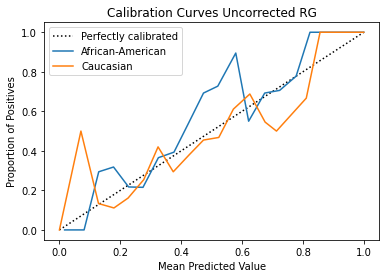

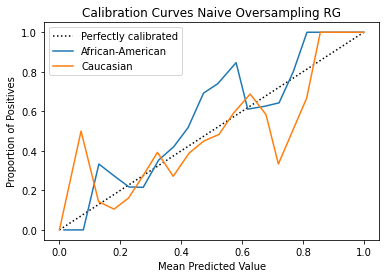

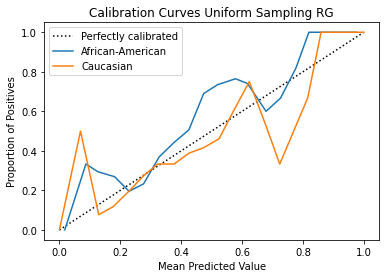

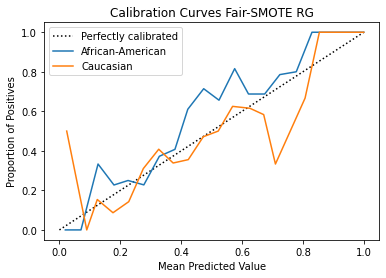

In [34]:
print_calib(data_uncorrected, model1, 'Uncorrected RG')
print_calib(data_naive_oversampling, model1, 'Naive Oversampling RG')
print_calib(data_uniform_sampling, model1, 'Uniform Sampling RG')
print_calib(data_fair_smote, model1, 'Fair-SMOTE RG')

# Logistic Regression

In [35]:
model2 = LogisticRegression(random_state=rs)

## Metrics per data set

### Uncorrected LR

In [36]:
model_metrics(data_uncorrected, model2)

Overall
Performance
Accuracy 0.65
AUC score 0.65
FNR 0.39
FPR 0.31
Sensitivity 0.61
Specificity 0.69 

Calibration
Negative Predictive Value 0.68
Positive Predicive Value 0.62
Group 0 
Performance
Accuracy 0.66
AUC score 0.66
FNR 0.27
FPR 0.41
Sensitivity 0.73
Specificity 0.59 

Calibration
Negative Predictive Value 0.69
Positive Predicive Value 0.63
Group 1 
Performance
Accuracy 0.65
AUC score 0.60
FNR 0.62
FPR 0.18
Sensitivity 0.38
Specificity 0.82 

Calibration
Negative Predictive Value 0.68
Positive Predicive Value 0.56
Equalized Odds
FNR difference 0.35
FPR difference 0.23
Average odds diffence 0.29

Calibration between groups
NPV difference 0.01
PPV difference 0.08


,base rate
race,
0,0.531906
1,0.393401


Base rate diff: 0.14
Class rate: 0.4768
Group rate: 0.3982


### Naive Oversampling LR

In [37]:
model_metrics(data_naive_oversampling, model2)

Overall
Performance
Accuracy 0.66
AUC score 0.66
FNR 0.36
FPR 0.32
Sensitivity 0.64
Specificity 0.68 

Calibration
Negative Predictive Value 0.69
Positive Predicive Value 0.62
Group 0 
Performance
Accuracy 0.68
AUC score 0.68
FNR 0.33
FPR 0.30
Sensitivity 0.67
Specificity 0.70 

Calibration
Negative Predictive Value 0.68
Positive Predicive Value 0.69
Group 1 
Performance
Accuracy 0.62
AUC score 0.61
FNR 0.43
FPR 0.35
Sensitivity 0.57
Specificity 0.65 

Calibration
Negative Predictive Value 0.71
Positive Predicive Value 0.50
Equalized Odds
FNR difference 0.09
FPR difference 0.05
Average odds diffence 0.07

Calibration between groups
NPV difference 0.03
PPV difference 0.18


,base rate
race,
0,0.5
1,0.5


Base rate diff: 0.00
Class rate: 0.5000
Group rate: 0.5000


### Uniform Sampling LR

In [38]:
model_metrics(data_uniform_sampling, model2)

Overall
Performance
Accuracy 0.65
AUC score 0.65
FNR 0.41
FPR 0.29
Sensitivity 0.59
Specificity 0.71 

Calibration
Negative Predictive Value 0.68
Positive Predicive Value 0.62
Group 0 
Performance
Accuracy 0.67
AUC score 0.67
FNR 0.39
FPR 0.27
Sensitivity 0.61
Specificity 0.73 

Calibration
Negative Predictive Value 0.65
Positive Predicive Value 0.69
Group 1 
Performance
Accuracy 0.63
AUC score 0.62
FNR 0.45
FPR 0.32
Sensitivity 0.55
Specificity 0.68 

Calibration
Negative Predictive Value 0.71
Positive Predicive Value 0.52
Equalized Odds
FNR difference 0.05
FPR difference 0.05
Average odds diffence 0.05

Calibration between groups
NPV difference 0.06
PPV difference 0.17


,base rate
race,
0,0.47669
1,0.476825


Base rate diff: 0.00
Class rate: 0.4767
Group rate: 0.3981


### Fair-SMOTE LR

In [39]:
model_metrics(data_fair_smote, model2)

Overall
Performance
Accuracy 0.65
AUC score 0.65
FNR 0.38
FPR 0.33
Sensitivity 0.62
Specificity 0.67 

Calibration
Negative Predictive Value 0.68
Positive Predicive Value 0.61
Group 0 
Performance
Accuracy 0.67
AUC score 0.67
FNR 0.36
FPR 0.30
Sensitivity 0.64
Specificity 0.70 

Calibration
Negative Predictive Value 0.67
Positive Predicive Value 0.68
Group 1 
Performance
Accuracy 0.61
AUC score 0.61
FNR 0.42
FPR 0.37
Sensitivity 0.58
Specificity 0.63 

Calibration
Negative Predictive Value 0.71
Positive Predicive Value 0.50
Equalized Odds
FNR difference 0.06
FPR difference 0.07
Average odds diffence 0.06

Calibration between groups
NPV difference 0.05
PPV difference 0.18


,base rate
race,
0,0.5
1,0.5


Base rate diff: 0.00
Class rate: 0.5000
Group rate: 0.5000


## Reliability diagrams

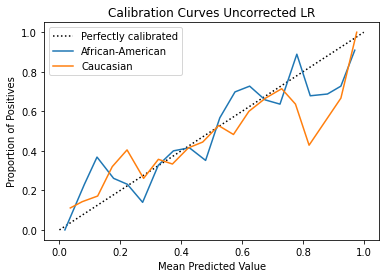

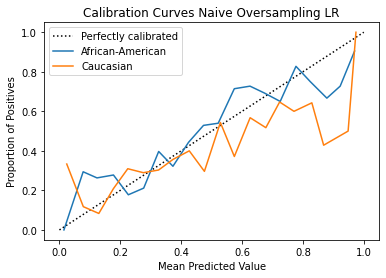

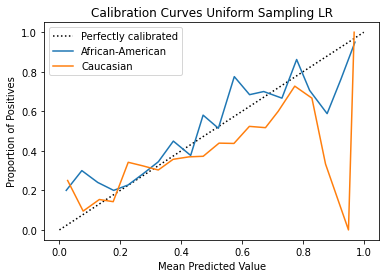

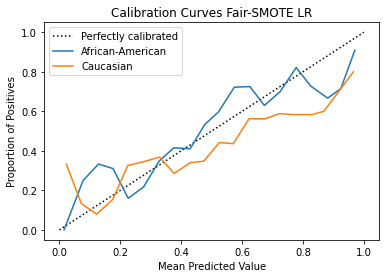

In [40]:
print_calib(data_uncorrected, model2, 'Uncorrected LR')
print_calib(data_naive_oversampling, model2, 'Naive Oversampling LR')
print_calib(data_uniform_sampling, model2, 'Uniform Sampling LR')
print_calib(data_fair_smote, model2, 'Fair-SMOTE LR')

# Decision Tree Classifier

In [41]:
model3 = DecisionTreeClassifier(random_state=rs)

## Metrics per data set

### Uncorrected DT

In [42]:
model_metrics(data_uncorrected, model3)

Overall
Performance
Accuracy 0.62
AUC score 0.61
FNR 0.44
FPR 0.34
Sensitivity 0.56
Specificity 0.66 

Calibration
Negative Predictive Value 0.65
Positive Predicive Value 0.58
Group 0 
Performance
Accuracy 0.62
AUC score 0.62
FNR 0.38
FPR 0.39
Sensitivity 0.62
Specificity 0.61 

Calibration
Negative Predictive Value 0.62
Positive Predicive Value 0.61
Group 1 
Performance
Accuracy 0.61
AUC score 0.58
FNR 0.57
FPR 0.27
Sensitivity 0.43
Specificity 0.73 

Calibration
Negative Predictive Value 0.67
Positive Predicive Value 0.50
Equalized Odds
FNR difference 0.19
FPR difference 0.12
Average odds diffence 0.16

Calibration between groups
NPV difference 0.05
PPV difference 0.11


,base rate
race,
0,0.531906
1,0.393401


Base rate diff: 0.14
Class rate: 0.4768
Group rate: 0.3982


### Naive Oversampling DT

In [43]:
model_metrics(data_naive_oversampling, model3)

Overall
Performance
Accuracy 0.60
AUC score 0.60
FNR 0.42
FPR 0.37
Sensitivity 0.58
Specificity 0.63 

Calibration
Negative Predictive Value 0.64
Positive Predicive Value 0.56
Group 0 
Performance
Accuracy 0.61
AUC score 0.61
FNR 0.39
FPR 0.39
Sensitivity 0.61
Specificity 0.61 

Calibration
Negative Predictive Value 0.61
Positive Predicive Value 0.61
Group 1 
Performance
Accuracy 0.59
AUC score 0.58
FNR 0.50
FPR 0.35
Sensitivity 0.50
Specificity 0.65 

Calibration
Negative Predictive Value 0.68
Positive Predicive Value 0.47
Equalized Odds
FNR difference 0.11
FPR difference 0.04
Average odds diffence 0.08

Calibration between groups
NPV difference 0.06
PPV difference 0.13


,base rate
race,
0,0.5
1,0.5


Base rate diff: 0.00
Class rate: 0.5000
Group rate: 0.5000


### Unoform Sampling DT

In [44]:
model_metrics(data_uniform_sampling, model3)

Overall
Performance
Accuracy 0.60
AUC score 0.59
FNR 0.48
FPR 0.34
Sensitivity 0.52
Specificity 0.66 

Calibration
Negative Predictive Value 0.63
Positive Predicive Value 0.56
Group 0 
Performance
Accuracy 0.62
AUC score 0.62
FNR 0.46
FPR 0.30
Sensitivity 0.54
Specificity 0.70 

Calibration
Negative Predictive Value 0.61
Positive Predicive Value 0.64
Group 1 
Performance
Accuracy 0.57
AUC score 0.55
FNR 0.51
FPR 0.38
Sensitivity 0.49
Specificity 0.62 

Calibration
Negative Predictive Value 0.66
Positive Predicive Value 0.44
Equalized Odds
FNR difference 0.06
FPR difference 0.08
Average odds diffence 0.07

Calibration between groups
NPV difference 0.05
PPV difference 0.20


,base rate
race,
0,0.47669
1,0.476825


Base rate diff: 0.00
Class rate: 0.4767
Group rate: 0.3981


### Fair-SMOTE DT

In [45]:
model_metrics(data_fair_smote, model3)

Overall
Performance
Accuracy 0.60
AUC score 0.60
FNR 0.44
FPR 0.36
Sensitivity 0.56
Specificity 0.64 

Calibration
Negative Predictive Value 0.64
Positive Predicive Value 0.56
Group 0 
Performance
Accuracy 0.61
AUC score 0.61
FNR 0.41
FPR 0.37
Sensitivity 0.59
Specificity 0.63 

Calibration
Negative Predictive Value 0.61
Positive Predicive Value 0.61
Group 1 
Performance
Accuracy 0.60
AUC score 0.58
FNR 0.50
FPR 0.34
Sensitivity 0.50
Specificity 0.66 

Calibration
Negative Predictive Value 0.68
Positive Predicive Value 0.47
Equalized Odds
FNR difference 0.09
FPR difference 0.02
Average odds diffence 0.05

Calibration between groups
NPV difference 0.07
PPV difference 0.14


,base rate
race,
0,0.5
1,0.5


Base rate diff: 0.00
Class rate: 0.5000
Group rate: 0.5000


## Reliability diagrams

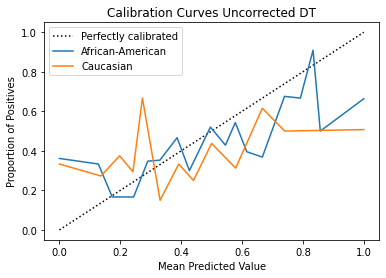

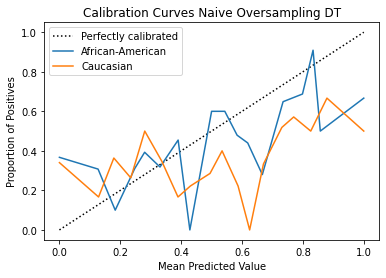

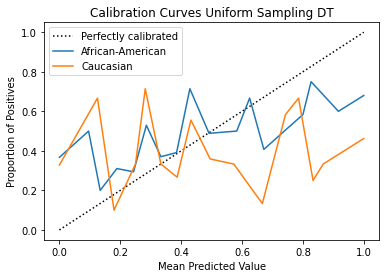

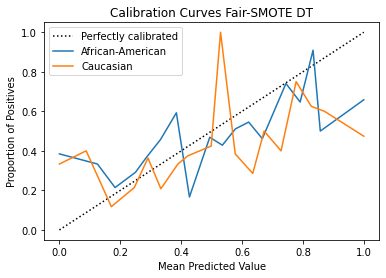

In [46]:
print_calib(data_uncorrected, model3, 'Uncorrected DT')
print_calib(data_naive_oversampling, model3, 'Naive Oversampling DT')
print_calib(data_uniform_sampling, model3, 'Uniform Sampling DT')
print_calib(data_fair_smote, model3, 'Fair-SMOTE DT')

# Random Forest Classifier

In [47]:
model4 = RandomForestClassifier(random_state=rs)

## Metrics per data set

### Uncorrected RF

In [48]:
model_metrics(data_uncorrected, model4)

Overall
Performance
Accuracy 0.63
AUC score 0.63
FNR 0.39
FPR 0.36
Sensitivity 0.61
Specificity 0.64 

Calibration
Negative Predictive Value 0.67
Positive Predicive Value 0.58
Group 0 
Performance
Accuracy 0.63
AUC score 0.63
FNR 0.31
FPR 0.43
Sensitivity 0.69
Specificity 0.57 

Calibration
Negative Predictive Value 0.65
Positive Predicive Value 0.61
Group 1 
Performance
Accuracy 0.62
AUC score 0.59
FNR 0.53
FPR 0.28
Sensitivity 0.47
Specificity 0.72 

Calibration
Negative Predictive Value 0.69
Positive Predicive Value 0.51
Equalized Odds
FNR difference 0.22
FPR difference 0.15
Average odds diffence 0.18

Calibration between groups
NPV difference 0.04
PPV difference 0.11


,base rate
race,
0,0.531906
1,0.393401


Base rate diff: 0.14
Class rate: 0.4768
Group rate: 0.3982


### Naive Oversampling RF

In [49]:
model_metrics(data_naive_oversampling, model4)

Overall
Performance
Accuracy 0.62
AUC score 0.62
FNR 0.38
FPR 0.38
Sensitivity 0.62
Specificity 0.62 

Calibration
Negative Predictive Value 0.66
Positive Predicive Value 0.57
Group 0 
Performance
Accuracy 0.63
AUC score 0.63
FNR 0.33
FPR 0.40
Sensitivity 0.67
Specificity 0.60 

Calibration
Negative Predictive Value 0.64
Positive Predicive Value 0.62
Group 1 
Performance
Accuracy 0.60
AUC score 0.59
FNR 0.47
FPR 0.36
Sensitivity 0.53
Specificity 0.64 

Calibration
Negative Predictive Value 0.69
Positive Predicive Value 0.48
Equalized Odds
FNR difference 0.13
FPR difference 0.04
Average odds diffence 0.09

Calibration between groups
NPV difference 0.04
PPV difference 0.14


,base rate
race,
0,0.5
1,0.5


Base rate diff: 0.00
Class rate: 0.5000
Group rate: 0.5000


### Uniform Sampling RF

In [50]:
model_metrics(data_uniform_sampling, model4)

Overall
Performance
Accuracy 0.61
AUC score 0.60
FNR 0.43
FPR 0.36
Sensitivity 0.57
Specificity 0.64 

Calibration
Negative Predictive Value 0.64
Positive Predicive Value 0.56
Group 0 
Performance
Accuracy 0.62
AUC score 0.62
FNR 0.42
FPR 0.35
Sensitivity 0.58
Specificity 0.65 

Calibration
Negative Predictive Value 0.61
Positive Predicive Value 0.62
Group 1 
Performance
Accuracy 0.59
AUC score 0.58
FNR 0.47
FPR 0.38
Sensitivity 0.53
Specificity 0.62 

Calibration
Negative Predictive Value 0.68
Positive Predicive Value 0.47
Equalized Odds
FNR difference 0.05
FPR difference 0.03
Average odds diffence 0.04

Calibration between groups
NPV difference 0.07
PPV difference 0.16


,base rate
race,
0,0.47669
1,0.476825


Base rate diff: 0.00
Class rate: 0.4767
Group rate: 0.3981


### Fair-SMOTE RF

In [51]:
model_metrics(data_fair_smote, model4)

Overall
Performance
Accuracy 0.62
AUC score 0.62
FNR 0.38
FPR 0.37
Sensitivity 0.62
Specificity 0.63 

Calibration
Negative Predictive Value 0.67
Positive Predicive Value 0.58
Group 0 
Performance
Accuracy 0.63
AUC score 0.63
FNR 0.35
FPR 0.39
Sensitivity 0.65
Specificity 0.61 

Calibration
Negative Predictive Value 0.64
Positive Predicive Value 0.62
Group 1 
Performance
Accuracy 0.62
AUC score 0.60
FNR 0.45
FPR 0.34
Sensitivity 0.55
Specificity 0.66 

Calibration
Negative Predictive Value 0.70
Positive Predicive Value 0.50
Equalized Odds
FNR difference 0.10
FPR difference 0.05
Average odds diffence 0.08

Calibration between groups
NPV difference 0.06
PPV difference 0.12


,base rate
race,
0,0.5
1,0.5


Base rate diff: 0.00
Class rate: 0.5000
Group rate: 0.5000


## Reliability diagrams

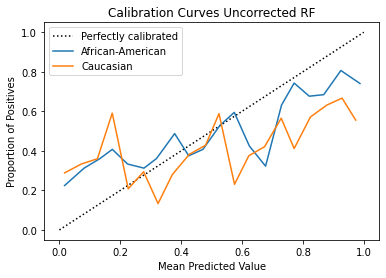

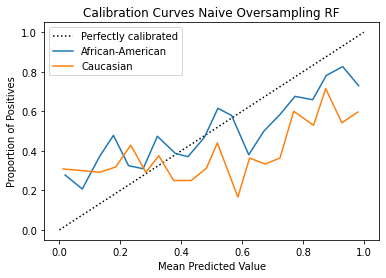

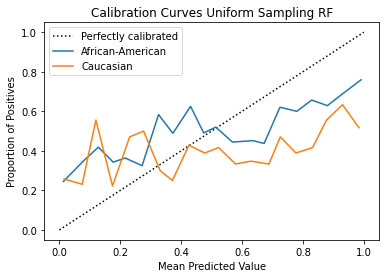

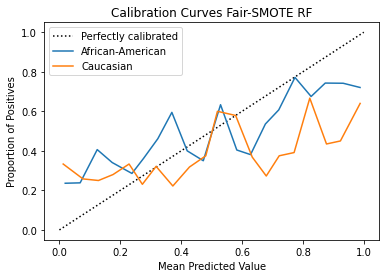

In [52]:
print_calib(data_uncorrected, model4, 'Uncorrected RF')
print_calib(data_naive_oversampling, model4, 'Naive Oversampling RF')
print_calib(data_uniform_sampling, model4, 'Uniform Sampling RF')
print_calib(data_fair_smote, model4, 'Fair-SMOTE RF')